# Exploring GPT2

We will start with the basics: using a [pre-trained GPT2](https://huggingface.co/openai-community/gpt2), accessing the attention weights throughout the model, and doing a small dive into its architecture. Let's begin.

In [1]:
# Use the smallest GPT2 model
from transformers import GPT2Tokenizer, GPT2Model

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = 'It was the best of times, it was the worst of times'
encoded_input = tokenizer(text, return_tensors='pt')


In [13]:
encoded_input

{'input_ids': tensor([[1026,  373,  262, 1266,  286, 1661,   11,  340,  373,  262, 5290,  286,
         1661]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:
len(encoded_input.input_ids[0])

13

So basically, every word is passed to the network as an `id` in  a dictionary, including the comma

In [14]:
output = model(**encoded_input)

In [4]:
dir(output)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'attentions',
 'clear',
 'copy',
 'cross_attentions',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'last_hidden_state',
 'move_to_end',
 'past_key_values',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [9]:
output.last_hidden_state.shape

torch.Size([1, 13, 768])

We can also get the attention maps:

In [15]:
model = GPT2Model.from_pretrained('gpt2', output_attentions=True)
output = model(**encoded_input)

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [18]:
dir(output)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'attentions',
 'clear',
 'copy',
 'cross_attentions',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'last_hidden_state',
 'move_to_end',
 'past_key_values',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [31]:
print(f'Number of layers: {len(output.attentions)}')
print(f'Number of heads: {output.attentions[0].shape[1]}')
print(f'Attention map shape: {output.attentions[0].shape}')

Number of layers: 12
Number of heads: 12
Attention map shape: torch.Size([1, 12, 13, 13])


As expected: we have 12 layers and 12 heads in this model:

In [23]:
model.config

GPT2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "output_attentions": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.46.1",
  "use_cache": true,
  "vocab_size": 50257
}

We will now plot the attention maps for each head in each layer:

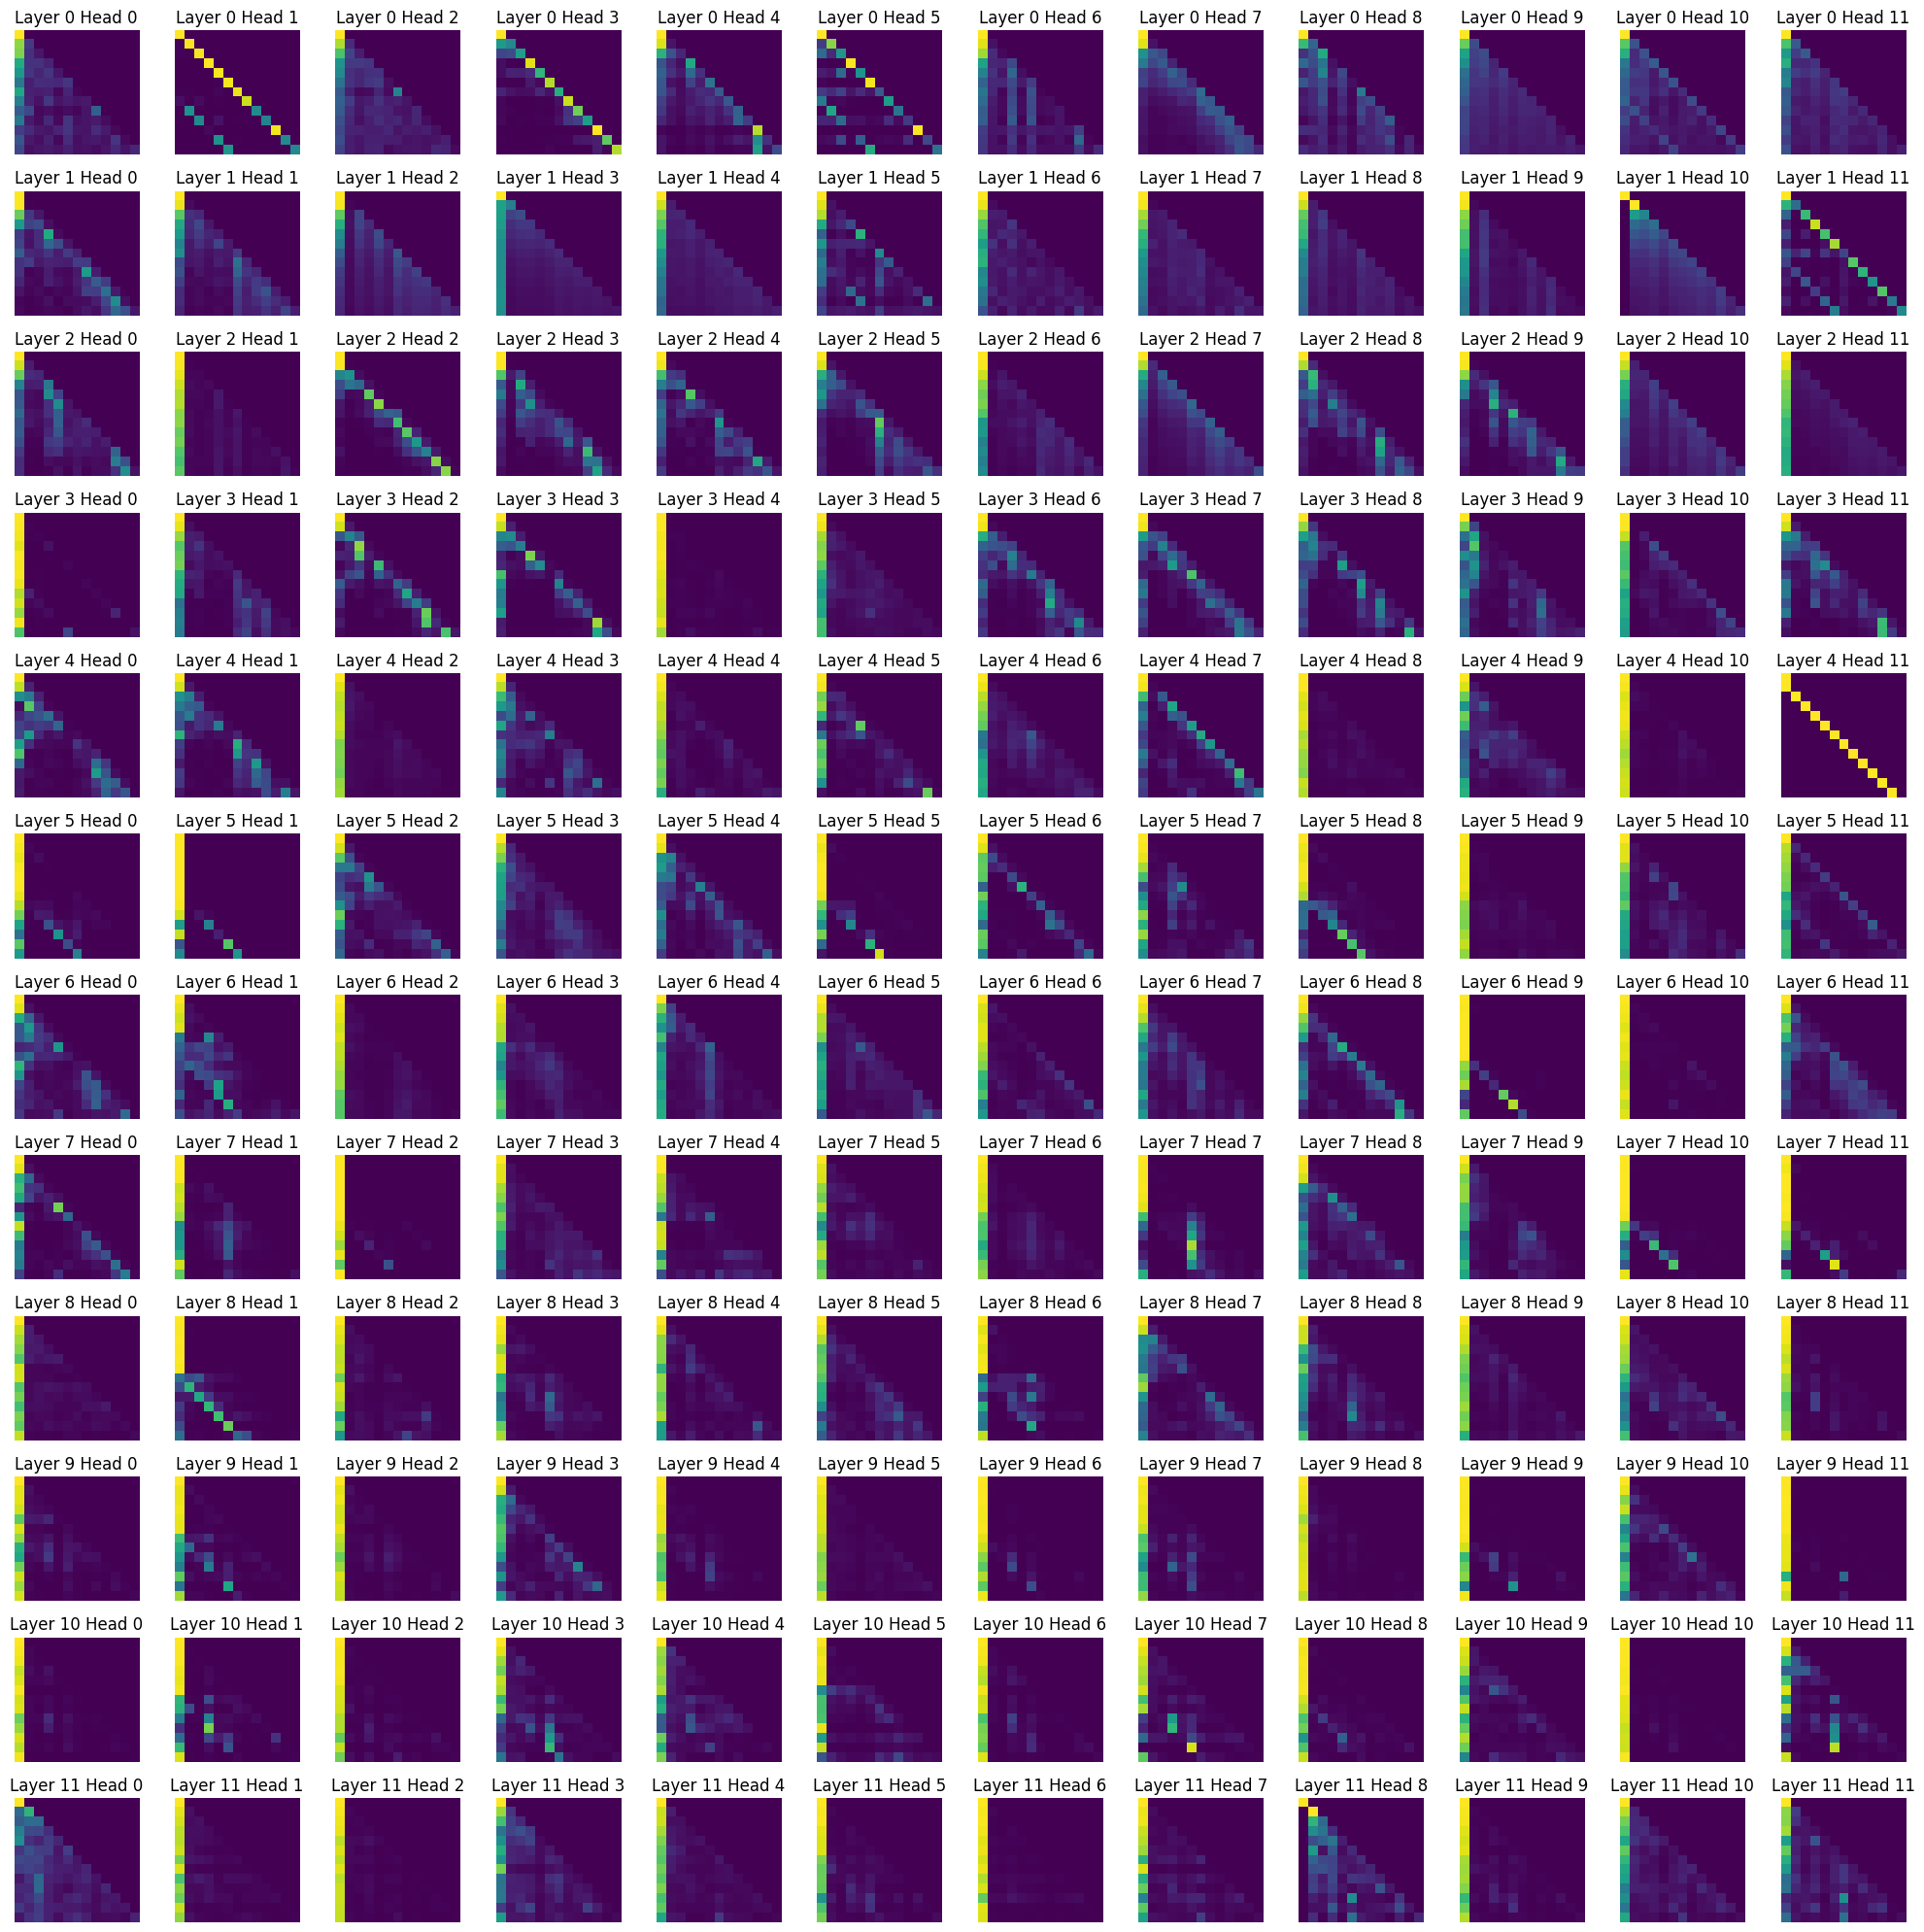

In [24]:
import matplotlib.pyplot as plt

n_layers = model.config.n_layer
n_heads = model.config.n_head

fig, axs = plt.subplots(n_layers, n_heads, figsize=(20, 20))

for i, layer in enumerate(output.attentions):
    for j, head in enumerate(layer[0]):
        axs[i, j].imshow(head.detach().numpy())
        axs[i, j].set_title(f'Layer {i} Head {j}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Perhaps it's easier to look into each average attention map

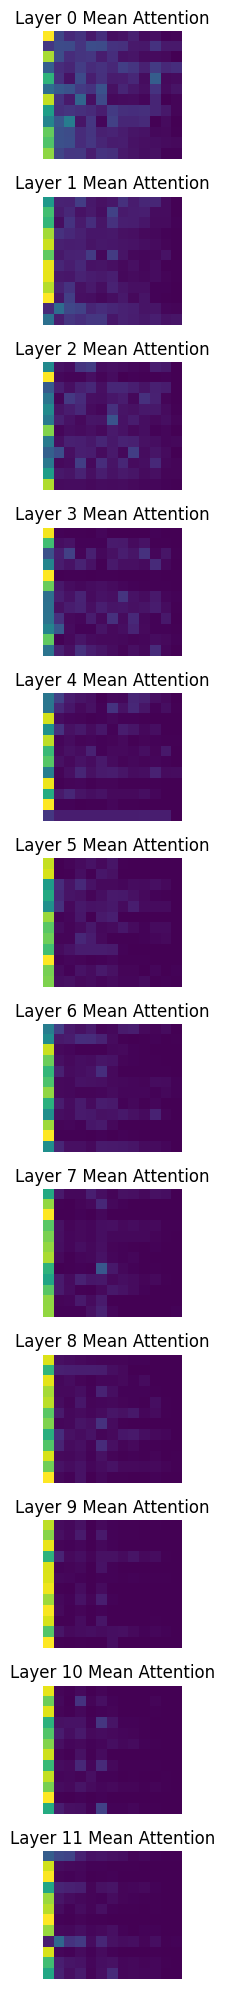

In [29]:
fig, axs = plt.subplots(n_layers, 1, figsize=(20, 20))

for i, layer in enumerate(output.attentions):
    axs[i].imshow(layer[0].mean(dim=1).detach().numpy())
    axs[i].set_title(f'Layer {i} Mean Attention')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

This is wrong: why are there values greater than zero above the diagonal?